<h1> Machine Learning - Test 2</h1>

<h2> Auteurs </h2>

* Forestier Quentin
* Herzig Melvyn

<h2> Besoins </h2>

* Python 3.7
* Fichier requirement du laboratoire 7
* Pillow 9.1.1

<i>Ce travail est fortement inspiré de l'exemple 12 de la documentation officielle de PyEvolve.</i>
http://pyevolve.sourceforge.net/0_6rc1/examples.html#example-12-the-travelling-salesman-problem-tsp


<h3> Importations </h3>
La première partie consiste à importer PyEvolve de manière à pouvoir utiliser notre algorithme génétique, importer GeoPy pour calculer la distance entre les villes en tenant compte de la forme de la terre et finalement importer Pillow pour visualiser le résultat final grâce à une image.

In [348]:
# For GA algorithm
from pyevolve import GSimpleGA
from pyevolve import Selectors
from pyevolve import Statistics
from pyevolve import G1DList
from pyevolve import Mutators
from pyevolve import Crossovers
from pyevolve import Consts
from pyevolve import DBAdapters

import random

# For cities distances
from geopy.distance import geodesic as GD

# For solution display
PIL_SUPPORT = None
try:
   from PIL import Image, ImageDraw, ImageFont
   PIL_SUPPORT = True
except:
   PIL_SUPPORT = False

<h3> Matrice des distances </h3>
Dans cette première partie, nous créons la matrice de distances à partir des latitudes et longitudes des villes. La matrice des distances est importante car elle sera utilisée plus tard dans la fonction de "fitness".

Pour ce faire, nous zippons les listes de coordonnées pour obtenir un tuple (lat, long) par ville. Ensuite, nous créons la matrice des distances à partir de cette liste de tuples. 


In [349]:
# Cities latitudes
LAT = [16.47, 16.47, 20.09, 22.39, 25.23, 22.00, 20.47, 
       17.20, 16.30, 14.05, 16.53, 21.52, 19.41, 20.09]

# Cities longitudes
LON = [96.10, 94.44, 92.54, 93.37, 97.24, 96.05, 97.02, 
       96.29, 97.38, 98.12, 97.38, 95.59, 97.13, 94.55]

def compute_distances_matrix(coordinates):
    '''
    Compute a distance matrix based on list of (lat, lon).
    The cell [i, j] is the distance from the city i to the city j
    This is not an euclidean distance, but a distance that consider the earth spherical form.
    '''
    matrix={}
    for i, coordinate_src in enumerate(coordinates):
        for j, coordinate_dist in enumerate(coordinates):
            matrix[i, j] = GD(coordinate_src, coordinate_dist).km
    return matrix

distances_matrix = compute_distances_matrix(list(zip(LAT, LON)))

<h3> Fonction de fitness </h3>
Pour calculer la fitness d'un chromosome, nous calculons la distance totale du tour. 
Plus le tour est court, plus son fitness est petit.
Pour chaque index, nous calculons la distance au prochain index.
Ainsi pour l'index 0 nous obtenons la distance entre la ville à l'index 0 et la ville à l'index 1.
De la même manière, pour le dernier index, nous obtenons la distance jusqu'à la ville à l'index 0. 

In [350]:
def fitness_tour_length(chromosome_tour):
    """Compute the fitness of a tour/chromosome"""
    global distances_matrix
    tour_length = 0.0
    nb_cities = len(chromosome_tour)
    for i in range(nb_cities):
        j = (i + 1) % nb_cities  
        tour_length += distances_matrix[chromosome_tour[i], chromosome_tour[j]]
    return tour_length
    

<h3> Initialisation </h3>
Fonction permettant d'initialiser un génome. Un génome est initalisé avec le numéro des villes (de 0 à nombre de ville - 1). Il est initialisé aléatoirement sans doublon.

In [351]:
def genome_initializator(genome, **args):
   """ 
   Initialize a genome
   """
   genome.clearList()
   lst = [i for i in range(genome.getListSize())]

   for i in range(genome.getListSize()):
      choice = random.choice(lst)
      lst.remove(choice)
      genome.append(choice)

<h3>Affichage du résultat final</h3>
Cette fonction a été reprise et adaptée depuis la documentation de PyEvolve. Elle permet de créer une image qui représente graphiquement la solution d'un génome.

In [352]:
def write_tour_to_img(coords, tour, img_file):
    """ 
    The function to create an image of the result
    """
    padding=30
    coords=[(100*x+padding,100*y+padding) for (x,y) in coords]
    maxx,maxy,minx,miny=0,0,100000000,100000000
    for x,y in coords:
        maxx=max(x,maxx)
        maxy=max(y,maxy)
        minx=min(x,minx)
        miny=min(y,miny)
        
    maxx+=padding
    maxy+=padding
    minx-=padding
    miny-=padding
    img=Image.new("RGB", (int(maxx- minx), int(maxy - miny)),color=(255,255,255))

    font = ImageFont.truetype("arial.ttf", 30)

    d=ImageDraw.Draw(img);
    num_cities=len(tour)
    ellipse_size = 4
    
    for i in range(num_cities):
        j=(i+1)%num_cities
        city_i=tour[i]
        city_j=tour[j]
        x1,y1=coords[city_i]
        x2,y2=coords[city_j]
        d.line((int(x1 - minx),int(y1 - miny),int(x2 - minx),int(y2 - miny)),fill=(0,0,0), width=2)
        d.text((int(x1 - minx)+7,int(y1 - miny)-5),str(city_i),font=font,fill=(32,32,32), width=3)

    for x,y in coords:
        x,y=int(x)-minx,int(y)-miny
        d.ellipse((x-ellipse_size,y-ellipse_size,x+ellipse_size,y+ellipse_size),outline=(0,0,0),fill=(0,0,0))
    del d
    img.save(img_file, "PNG")

    print("The plot was saved into the %s file." % (img_file,))

<h3> Exécution </h3>
Cette partie démarre l'algorithme génétique et affiche le résultat final.

In [353]:
number_of_cities = len(LAT)

# Setting genome
genome = G1DList.G1DList(number_of_cities)
genome.setParams(rangemin=0, rangemax=number_of_cities - 1)

genome.evaluator.set(fitness_tour_length)
genome.crossover.set(Crossovers.G1DListCrossoverOX)
genome.initializator.set(genome_initializator)

# Setting the Genetic Algorithm
ga = GSimpleGA.GSimpleGA(genome)

ga.setMinimax(Consts.minimaxType["minimize"])
ga.selector.set(Selectors.GTournamentSelector)
ga.setCrossoverRate(0.9)
ga.setMutationRate(0.01)
ga.setGenerations(150)
ga.setPopulationSize(100)

# Record evolution results in a database for plotting
sqlite_adapter = DBAdapters.DBSQLite(identify="log_tsp")
ga.setDBAdapter(sqlite_adapter)

# Running
ga.evolve(freq_stats=100)
best = ga.bestIndividual()

print(best)

if PIL_SUPPORT:
    write_tour_to_img(list(zip(LAT, LON)), best, "tsp_result.png")
else:
      print("No PIL detected, cannot plot the graph !")

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw)             [8155.99(8569.59)/5587.54(5219.64)/6796.65(6796.65)]
Gen. 100 (66.67%): Max/Min/Avg Fitness(Raw)             [4237.20(5579.33)/3467.48(3346.76)/3531.00(3531.00)]
Gen. 150 (100.00%): Max/Min/Avg Fitness(Raw)             [4221.42(5735.60)/3463.57(3346.76)/3517.85(3517.85)]
Total time elapsed: 0.892 seconds.
- GenomeBase
	Score:			 3346.761974
	Fitness:		 3463.572529

	Params:		 {'rangemin': 0, 'rangemax': 13}

	Slot [Evaluator] (Count: 1)
		Name: fitness_tour_length - Weight: 0.50
		Doc: Compute the fitness of a tour/chromosome
	Slot [Initializator] (Count: 1)
		Name: genome_initializator - Weight: 0.50
		Doc:  
   Initialize a genome
   
	Slot [Mutator] (Count: 1)
		Name: G1DListMutatorSwap - Weight: 0.50
		Doc:  The mutator of G1DList, Swap Mutator

    .. note:: this mutator is :term:`Data Type Independent`

    
	Slot [Crossover] (Count: 1)
		Name: G1DListCrossoverOX - Weight: 0.50
		Doc:  The OX Crossover for G1DList  (order cross

<h3> Plotting </h3>
Cette dernière partie affiche deux plots qui détaillent l'évolution des performances de notre exécution de l'algorithme génétique.

Pyevolve 0.6 - Graph Plot Tool
By Christian S. Perone

Loading modules....
Loading database and creating graph...
150 generations found !


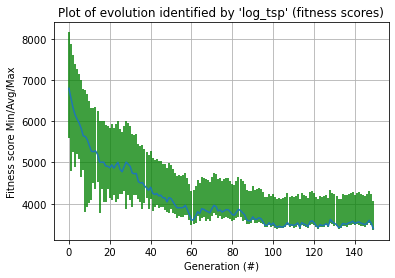

In [354]:
# Generate a graph showing the evolutionary results: fitness vs generations
%run C:\Users\melvy\miniconda3\envs\lab7\Scripts\pyevolve_graph.py -i log_tsp -2

Pyevolve 0.6 - Graph Plot Tool
By Christian S. Perone

Loading modules....
Loading database and creating graph...
150 generations found !


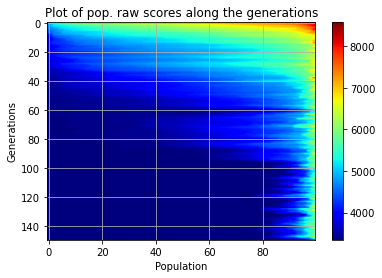

In [355]:
# Generate a heatmap of population fitness score distribution over generations
%run  C:\Users\melvy\miniconda3\envs\lab7\Scripts\pyevolve_graph.py -i log_tsp -8